In [ ]:
# Install jaxlib if not already done
!pip install -q git+https://github.com/mathisgerdes/continuous-flow-lft.git

In [1]:
import optax
import haiku as hk
import matplotlib.pyplot as plt
import numpy as np

from jaxlft import *

In [2]:
# a generator of random keys, with jax we need to manage these manually
seed = 42
rns = hk.PRNGSequence(seed)

# Lattice QFT

In [3]:
lattice_shape = (6, 6)
m2 = -4  # mass squared
lam = 6.975  # phi^4 coupling
theory = phi4.Phi4Theory(shape=lattice_shape, m2=m2, lam=lam)

In [4]:
# field configurations are real arrays of the fixed lattice shape
key = next(rns)
phi = jax.random.normal(key, lattice_shape)

In [5]:
# given a field configuration we can evaluate the action
theory.action(phi)

DeviceArray(553.05896, dtype=float32)

# Normalizing flow model

In [6]:
model_def = cnf.Phi4CNF()  # we'll use the default parameters for now

In [7]:
# given the model definition, we can generate a named tuple of pure model functions generated by haiku
model = model_def.transform(lattice_shape=lattice_shape)

In [8]:
# with jax/haiku parameters are explicit and separate from the pure model functions
params = model.init(next(rns))

In [9]:
# generate 10 random samples
phi_prior, logp_prior = model.prior(next(rns), 10)  # by default, prior is a unit normal; can be changed in model_def.transform

In [10]:
# flow forward
phi, logp = model.forward(params, phi_prior, logprob=logp_prior)

In [11]:
# the flow is initialized to be the identity transformation, so nothing yet happened
np.all(phi == phi_prior)

DeviceArray(True, dtype=bool)

In [12]:
# for conveience, prior and forward are also available as a combined function
phi, logp = model.sample(params, next(rns), 10)

In [13]:
phi.shape

(10, 6, 6)

# Machine learning

## Plotting functions 
These will be used later to monitor training.

In [14]:
def init_live_plot(figsize=(8, 4), logit_scale=True, **kwargs):
    fig, ax_ess = plt.subplots(1, 1, figsize=figsize, **kwargs)

    ess_line = plt.plot([0], [0.5], color='C0', label='ESS')
    plt.grid(False)
    plt.ylabel('ESS')
    if logit_scale:
        ax_ess.set_yscale('logit')
    else:
        plt.ylim(0, 1)

    ax_loss = ax_ess.twinx()
    loss_line = plt.plot([0], [1], color='C1', label='KL Loss')
    plt.grid(False)
    plt.ylabel('Loss')
    plt.xlabel('Steps')
    plt.legend(loc='upper right')

    lines = ess_line + loss_line
    plt.legend(lines, [line.get_label() for line in lines], loc='upper center', ncol=2)

    setup = dict(
        fig=fig, ax_ess=ax_ess, ax_loss=ax_loss,
        ess_line=ess_line, loss_line=loss_line, logit=logit_scale)
    
    display_id = display(fig, display_id=True)
    setup['display_id'] = display_id

    return setup


def update_plots(history, setup, window_size=15):
    ess_line = setup['ess_line']
    loss_line = setup['loss_line']
    ax_loss = setup['ax_loss']
    ax_ess = setup['ax_ess']
    fig = setup['fig']

    ess = np.array(history['ess'])
    ess = moving_average(ess, window=window_size)
    steps = np.arange(len(ess))
    ess_line[0].set_ydata(ess)
    ess_line[0].set_xdata(steps)
    if setup['logit'] and len(ess) > 1:
        ax_ess.relim()
        ax_ess.autoscale_view()

    loss = np.array(history['loss'])
    loss = moving_average(loss, window=window_size)
    loss_line[0].set_ydata(loss)
    loss_line[0].set_xdata(steps)
    if len(loss) > 1:
        ax_loss.relim()
        ax_loss.autoscale_view()

    setup['display_id'].update(fig)

## Loss function

In [15]:
# the loss is given in terms of the KL divergence

batch_size = 64  # number of samples to compute KL divergence

def _loss(params, key):
    x, logq = model.sample(params, key, batch_size)
    logp = -theory.action(x)
    dkl = reverse_dkl(logp, logq)
    return dkl, (logq, logp)

# using jax, we can generate the gradient function
value_and_grad = jax.value_and_grad(_loss, has_aux=True)

In [16]:
# choose an optimizer
lr = optax.exponential_decay(5e-3, 8000, 1e-1)
opt = optax.adam(lr, .8, .9)

In [17]:
# given parameters and optimizer state, do one update step
@jax.jit
def _update_step(key, params, opt_state):
    (loss, (logq, logp)), grad = value_and_grad(params, key)
    updates, opt_state = opt.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, effective_sample_size(logp, logq)

In [18]:
# we will later keep lists of the loss and ESS history, which we update here
def update_step(key, params, opt_state, history):
    params, opt_state, loss, ess = _update_step(key, params, opt_state)
    history['loss'].append(loss)
    history['ess'].append(ess)
    return params, opt_state

## Training

In [19]:
# set training parameters
epochs = 50  # number of epochs
epoch_size = 10  # update plot once per epoch

history = {
    'loss': [],
    'ess': [],
}

In [20]:
# initialize training
params = model.init(next(rns))
opt_state = opt.init(params)

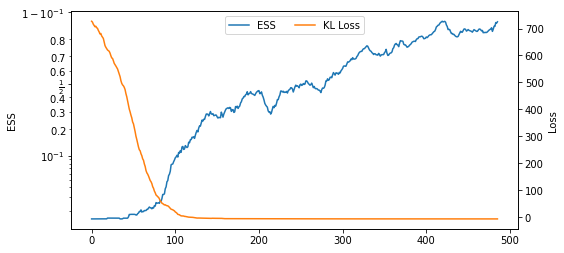

In [21]:
# initialize plotting
plot_config = init_live_plot()

for era in range(epochs):
    for epoch in range(epoch_size):
        params, opt_state = update_step(next(rns), params, opt_state, history)

    update_plots(history, plot_config)
plt.close()

# Generating samples

We can now use the trained model parameters to generate samples. To correct for bias in the proposals, we need to add a Metropolis-Hastings accept reject step.

In [22]:
# let's first look at some example field configurations generated by the flow
phis, logp = model.sample(params, next(rns), 10)

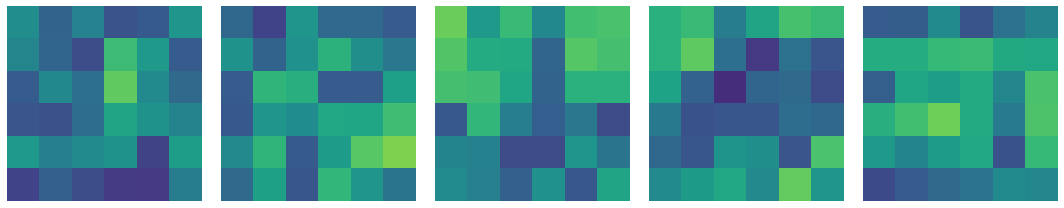

In [23]:
plt.figure(figsize=(15, 3))
for i in range(5):
    ax = plt.subplot(151 + i)
    plt.imshow(np.tanh(phis[i]), vmin=-1, vmax=1)
    ax.set_axis_off()

plt.tight_layout()

In [24]:
# A function 'mcmc_chain' that can be jit-compiled is already implemented.
# It uses the flow as proposal and implements a basic Metropolis-Hastings accept/reject step.

# first 1000-sample burn-in phase
mcmc_burnin = jax.jit(partial(
    mcmc_chain,
    sample=model.sample, 
    action=theory.action, 
    batch_size=32,  # how many new samples to generate each time we run out of proposals
    sample_count=1000))  # how many samples we want in total

In [25]:
_, _, initial = mcmc_burnin(next(rns), params)

In [26]:
# Now generate 10000 samples
mcmc_sample = jax.jit(partial(
    mcmc_chain,
    sample=model.sample, 
    action=theory.action, 
    batch_size=32,  # how many new samples to generate each time we run out of proposals
    sample_count=10000))  # how many samples we want in total

In [27]:
sample, accept_rate, _ = mcmc_sample(next(rns), params, initial=initial)
print(f'Acceptance rate: {accept_rate*100:.2f}%')

Acceptance rate: 79.07%


In [28]:
sample.shape

(10000, 6, 6)

In [29]:
# based on the generated samples, we can compute observables
two_point = phi4.two_point_central(sample)

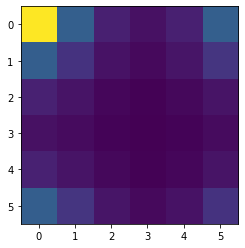

In [30]:
plt.imshow(two_point)

In [33]:
# The drop off of the two point function is measured by the correlation length
corr_len = phi4.correlation_length(two_point)
# relative to the lattice size, this should be approximately 4 if the lambda chosen at the top was used
lattice_shape[0] / corr_len

DeviceArray(3.9820821, dtype=float32)